In [57]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_parquet("dna_pw_20250225.parquet")

In [5]:
data.head()

,MASKED_ID_NUM,CL_ID2,CL_ID4,IDV_OCP_TYP_ID,NBR_DPND,GENERATION,GENDER,MARITAL_STATUS,DIGITAL_FLAG,RISK_APPETITE,...,OF_CLUB,RETIREES_CLUB,MILLENNIAL_CLUB,EXECUTIVES_CLUB,PROFESSIONAL_CLUB,NEW_MERCH_NAME,TXN_AMT_TOT,TXN_AMT_AVE,TXN_CNT,MOST_COMMON_INDUSTRY
0,4016083633,a.Private,a1.Private,STUDENT,3.0,BOOMERS,FEMALE,MARRIED,TRADITIONAL,AGGRESSIVE,...,Y,N,Y,N,N,IN ROOM DINING,80099.0,14531.0,1.0,Record Stores
1,4016083633,a.Private,a1.Private,SELFEMPLOYED,3.0,GEN_X,MALE,MARRIED,DIGITAL,AGGRESSIVE,...,Y,Y,N,N,N,VANS 756,41075.0,2753.0,2.0,Drug Stores And Pharmacies
2,4016083633,a.Private,a1.Private,SELFEMPLOYED,3.0,BOOMERS,FEMALE,MARRIED,DIGITAL,NO_DATA,...,Y,Y,N,N,N,ZHIGUANKEJI,0.0,14504.0,2.0,Grocery Stores And Supermarkets
3,4016083633,a.Private,a1.Private,EMPLOYED,3.0,BOOMERS,FEMALE,MARRIED,DIGITAL,NO_DATA,...,Y,Y,N,Y,N,ST. LUKE'S MEDICAL CENTER,0.0,5338.0,2.0,Education
4,4016083633,a.Private,a1.Private,SELFEMPLOYED,3.0,GEN_X,FEMALE,MARRIED,DIGITAL,NO_DATA,...,N,N,N,N,N,NETFLIX,12695.0,0.0,2.0,No Industry Label


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85142 entries, 0 to 85141
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MASKED_ID_NUM         85142 non-null  int64  
 1   CL_ID2                85142 non-null  object 
 2   CL_ID4                85142 non-null  object 
 3   IDV_OCP_TYP_ID        85142 non-null  object 
 4   NBR_DPND              85142 non-null  float64
 5   GENERATION            85142 non-null  object 
 6   GENDER                85142 non-null  object 
 7   MARITAL_STATUS        85142 non-null  object 
 8   DIGITAL_FLAG          85142 non-null  object 
 9   RISK_APPETITE         85142 non-null  object 
 10  TRAVELLER             85142 non-null  object 
 11  GEODIVERSITY          85142 non-null  object 
 12  REGION                85142 non-null  object 
 13  HOSPITAL_PAYOR        85142 non-null  object 
 14  HMO_MEMBER            85142 non-null  object 
 15  ENVIRONMENTAL_AFF  

In [11]:
data = data.drop(columns=["MASKED_ID_NUM", "CL_ID2", "CL_ID4"])

### Exploratory Data Analysis

#### Spending Behavior by Generation & Gender

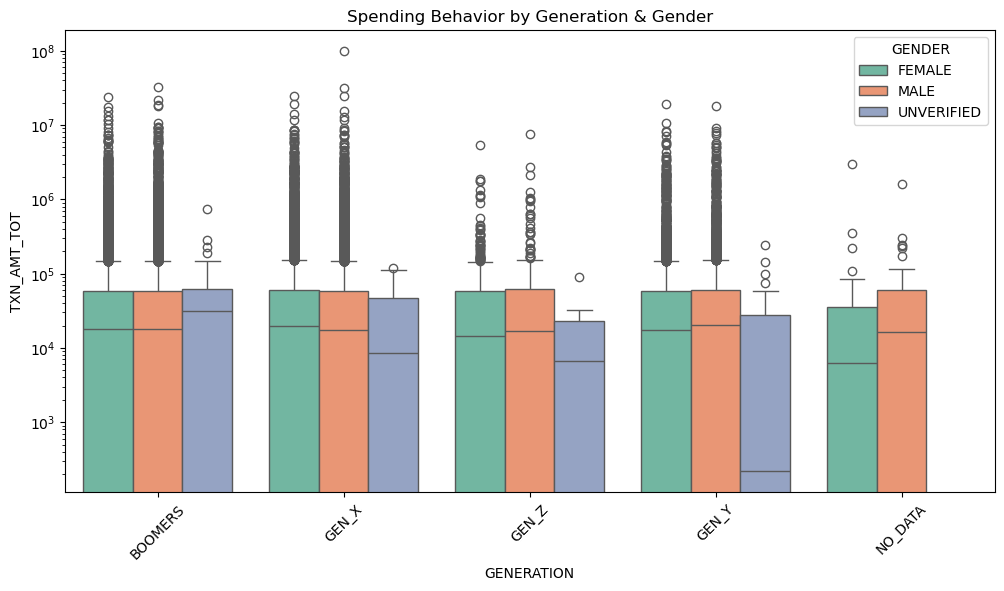

In [72]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x="GENERATION", y="TXN_AMT_TOT", hue="GENDER", palette="Set2")
plt.title("Spending Behavior by Generation & Gender")
plt.xticks(rotation=45)
plt.yscale("log")  # Use log scale for better visualization
plt.show()

#### Transaction Count by Generation & Digital Flag

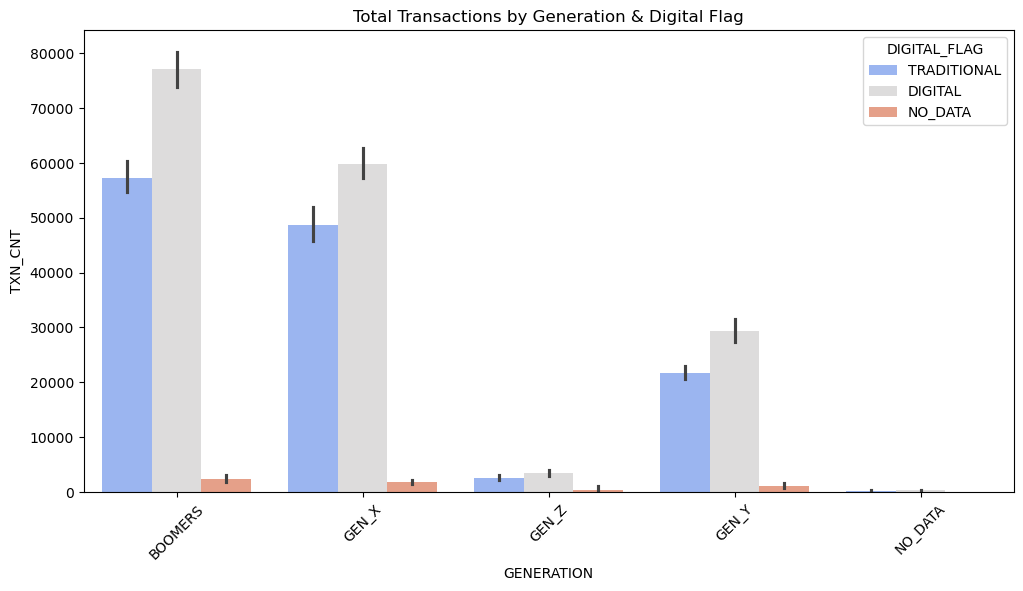

In [74]:
plt.figure(figsize=(12, 6))
sns.barplot(data=data, x="GENERATION", y="TXN_CNT", hue="DIGITAL_FLAG", palette="coolwarm", estimator=sum)
plt.title("Total Transactions by Generation & Digital Flag")
plt.xticks(rotation=45)
plt.show()

#### Risk Appetite vs. Spending

C:\Users\Dianne Yumol\AppData\Local\Temp\ipykernel_27892\1000917979.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x="RISK_APPETITE", y="TXN_AMT_TOT", palette="viridis")


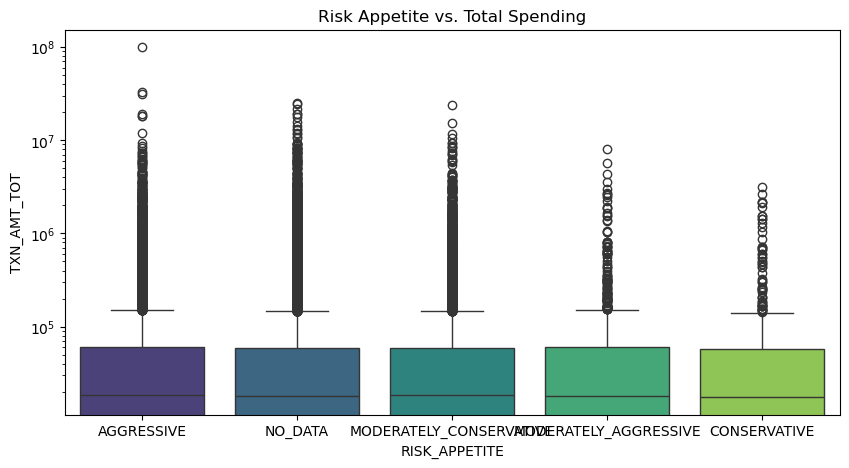

In [78]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=data, x="RISK_APPETITE", y="TXN_AMT_TOT", palette="viridis")
plt.title("Risk Appetite vs. Total Spending")
plt.yscale("log")
plt.show()

#### Top Spending Clubs

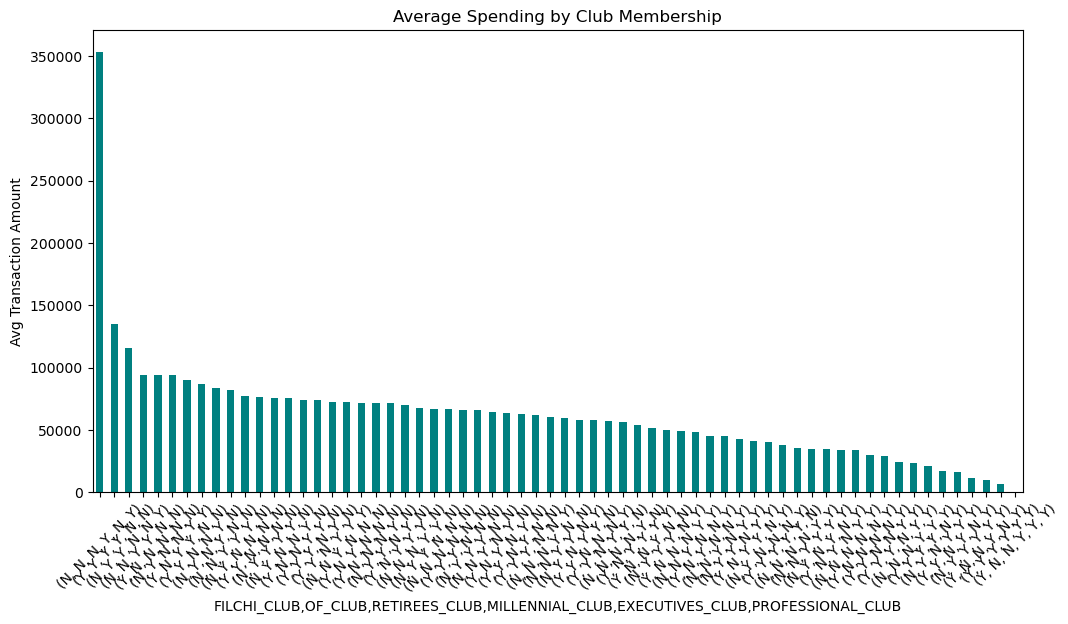

In [83]:
club_columns = ["FILCHI_CLUB", "OF_CLUB", "RETIREES_CLUB", "MILLENNIAL_CLUB", "EXECUTIVES_CLUB", "PROFESSIONAL_CLUB"]
club_spending = data.groupby(club_columns)["TXN_AMT_TOT"].mean().sort_values(ascending=False)
club_spending.plot(kind="bar", figsize=(12, 6), color="teal")
plt.title("Average Spending by Club Membership")
plt.ylabel("Avg Transaction Amount")
plt.xticks(rotation=45)
plt.show()

#### Industry Preferences by Generation

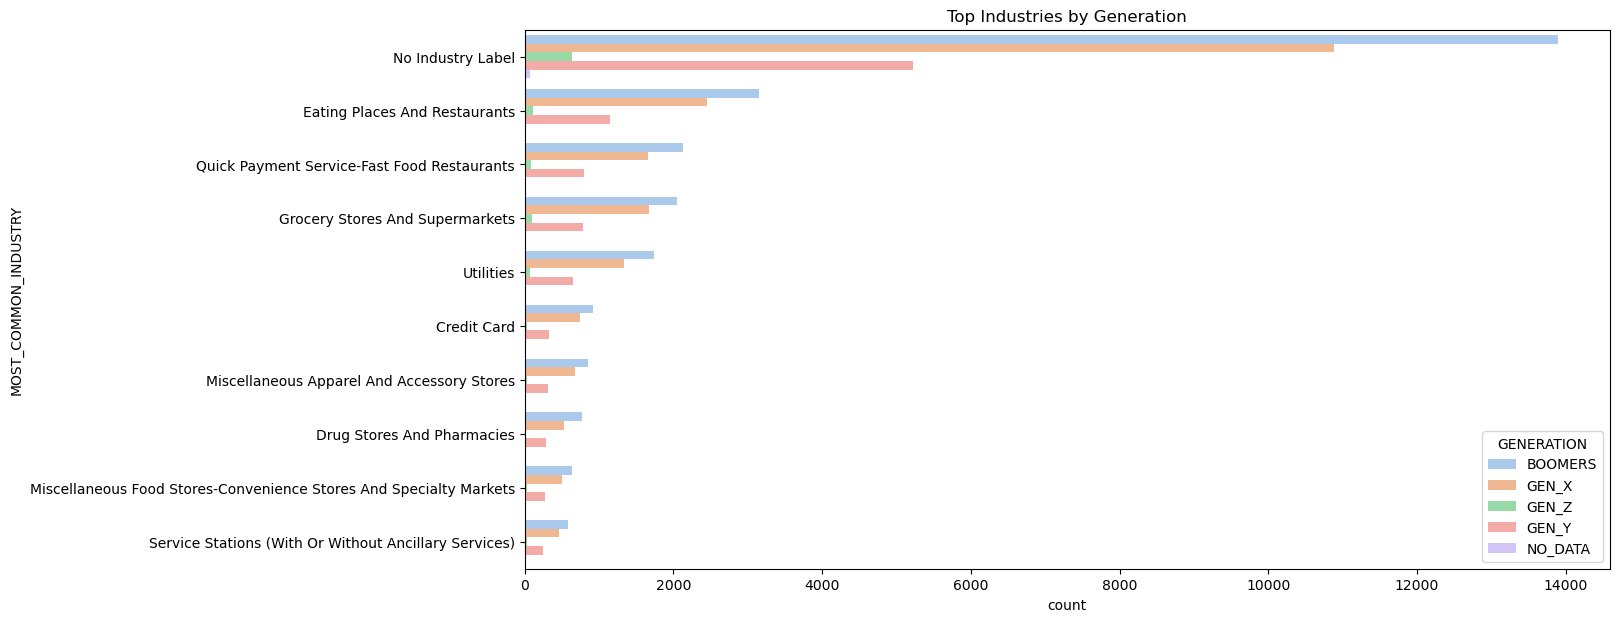

In [88]:
plt.figure(figsize=(14, 7))
sns.countplot(data=data, y="MOST_COMMON_INDUSTRY", hue="GENERATION", palette="pastel", order=data["MOST_COMMON_INDUSTRY"].value_counts().index[:10])
plt.title("Top Industries by Generation")
plt.show()

### Principal Component Analysis

In [13]:
num_cols = ["NBR_DPND", "TXN_AMT_TOT", "TXN_AMT_AVE", "TXN_CNT"]
cat_cols = [
    "IDV_OCP_TYP_ID", "GENERATION", "GENDER", "MARITAL_STATUS", "DIGITAL_FLAG", 
    "RISK_APPETITE", "TRAVELLER", "GEODIVERSITY", "REGION", "HOSPITAL_PAYOR", 
    "HMO_MEMBER", "ENVIRONMENTAL_AFF", "HUMANITARIAN_AFF", "RELIGIOUS_AFF", 
    "FILCHI_CLUB", "OF_CLUB", "RETIREES_CLUB", "MILLENNIAL_CLUB", "EXECUTIVES_CLUB", 
    "PROFESSIONAL_CLUB", "NEW_MERCH_NAME", "MOST_COMMON_INDUSTRY"
]

# Create transformers
num_transformer = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
cat_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore'))

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ]
)

In [21]:
data_num_transformed = SimpleImputer(strategy='median').fit_transform(data[num_cols])
data_num_scaled = StandardScaler().fit_transform(data_num_transformed)

vif_data = pd.DataFrame()
vif_data["Feature"] = num_cols
vif_data["VIF"] = [variance_inflation_factor(data_num_scaled, i) for i in range(len(num_cols))]
print("Variance Inflation Factor (VIF):")
print(vif_data)

Variance Inflation Factor (VIF):
       Feature       VIF
0     NBR_DPND  1.000156
1  TXN_AMT_TOT  1.255199
2  TXN_AMT_AVE  1.196997
3      TXN_CNT  1.055813


In [23]:
pca = PCA(n_components=10)  # Adjust n_components as needed
pipeline = make_pipeline(preprocessor, pca)

In [25]:
X_transformed = pipeline.fit_transform(data)

pca_df = pd.DataFrame(X_transformed, columns=[f'PC{i+1}' for i in range(X_transformed.shape[1])])

print(pca_df.head())

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.045741  1.016911  0.162927  0.101661 -0.857671 -0.528232 -0.736504   
1 -0.140381  0.981888  0.321662  0.063566  0.888200  0.615096  0.451970   
2 -0.114576  1.000262  0.233875 -0.057401 -0.477912  1.063620  0.438257   
3 -0.199253  0.982178  0.297024  0.015155 -0.478501  1.051949  0.405659   
4 -0.217412  0.956036  0.321042  0.134861 -0.933632 -0.272392  0.675422   

        PC8       PC9      PC10  
0  0.567437  0.294695  0.620399  
1  0.607275  0.176203 -0.814937  
2  0.600233  0.219047  0.675975  
3  0.573107  0.244784  0.658013  
4 -0.655760  0.650689 -0.854911  


In [27]:
feature_names = (
    num_cols + 
    list(preprocessor.named_transformers_['cat'].named_steps['onehotencoder'].get_feature_names_out(cat_cols))
)

# Get PCA loadings
loadings = pd.DataFrame(pca.components_, columns=feature_names, index=[f'PC{i+1}' for i in range(pca.n_components_)])
print(loadings)

      NBR_DPND  TXN_AMT_TOT  TXN_AMT_AVE   TXN_CNT  IDV_OCP_TYP_ID_CLERICAL  \
PC1   0.030422     0.702265     0.620239  0.347913                 0.000181   
PC2   0.936499    -0.015379     0.149098 -0.316743                 0.000365   
PC3   0.349050    -0.022676    -0.451777  0.820535                -0.000035   
PC4   0.001371     0.710706    -0.623006 -0.323896                -0.000204   
PC5   0.000762     0.015915    -0.018187 -0.013068                 0.000170   
PC6  -0.004631     0.006908    -0.001218 -0.006510                 0.000061   
PC7  -0.003298    -0.014887     0.006252  0.004111                -0.000370   
PC8  -0.006914     0.009668    -0.010832 -0.006672                -0.000415   
PC9   0.000597     0.012153    -0.009323 -0.000826                 0.000080   
PC10  0.001120     0.006466    -0.003157  0.002036                -0.000423   

      IDV_OCP_TYP_ID_EMPLOYED  IDV_OCP_TYP_ID_HOUSEWIFE  \
PC1                 -0.003622                  0.000167   
PC2         

In [29]:
top_features_per_pc = loadings.abs().apply(lambda x: x.nlargest(5).index.tolist(), axis=1)
print(top_features_per_pc)

PC1     [TXN_AMT_TOT, TXN_AMT_AVE, TXN_CNT, NBR_DPND, ...
PC2     [NBR_DPND, TXN_CNT, TXN_AMT_AVE, TXN_AMT_TOT, ...
PC3     [TXN_CNT, TXN_AMT_AVE, NBR_DPND, TXN_AMT_TOT, ...
PC4     [TXN_AMT_TOT, TXN_AMT_AVE, TXN_CNT, GENDER_MAL...
PC5     [GENDER_MALE, GENDER_FEMALE, RETIREES_CLUB_Y, ...
PC6     [RETIREES_CLUB_Y, RETIREES_CLUB_N, GENDER_MALE...
PC7     [DIGITAL_FLAG_DIGITAL, DIGITAL_FLAG_TRADITIONA...
PC8     [OF_CLUB_Y, OF_CLUB_N, FILCHI_CLUB_N, FILCHI_C...
PC9     [FILCHI_CLUB_N, FILCHI_CLUB_Y, OF_CLUB_Y, OF_C...
PC10    [GENERATION_BOOMERS, GENERATION_GEN_X, FILCHI_...
dtype: object


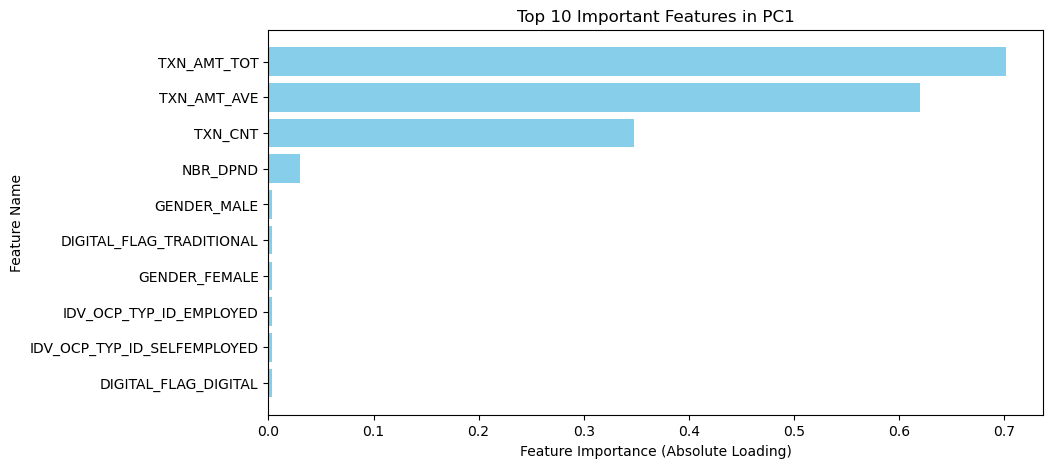

In [33]:
# Choose a principal component (e.g., PC1)
pc_index = 0  # 0 corresponds to PC1

# Sort features by absolute contribution
sorted_features = loadings.iloc[pc_index].abs().sort_values(ascending=False)

# Plot the top 10 features
plt.figure(figsize=(10, 5))
plt.barh(sorted_features.index[:10], sorted_features.values[:10], color='skyblue')
plt.xlabel("Feature Importance (Absolute Loading)")
plt.ylabel("Feature Name")
plt.title(f"Top 10 Important Features in PC{pc_index+1}")
plt.gca().invert_yaxis()
plt.show()

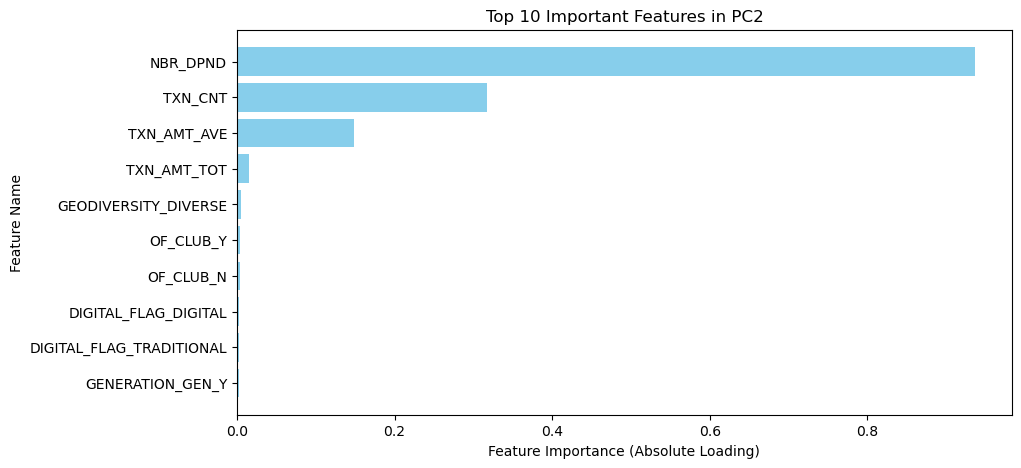

In [37]:
# Choose a principal component (e.g., PC1)
pc_index = 1  # 0 corresponds to PC1

# Sort features by absolute contribution
sorted_features = loadings.iloc[pc_index].abs().sort_values(ascending=False)

# Plot the top 10 features
plt.figure(figsize=(10, 5))
plt.barh(sorted_features.index[:10], sorted_features.values[:10], color='skyblue')
plt.xlabel("Feature Importance (Absolute Loading)")
plt.ylabel("Feature Name")
plt.title(f"Top 10 Important Features in PC{pc_index+1}")
plt.gca().invert_yaxis()
plt.show()

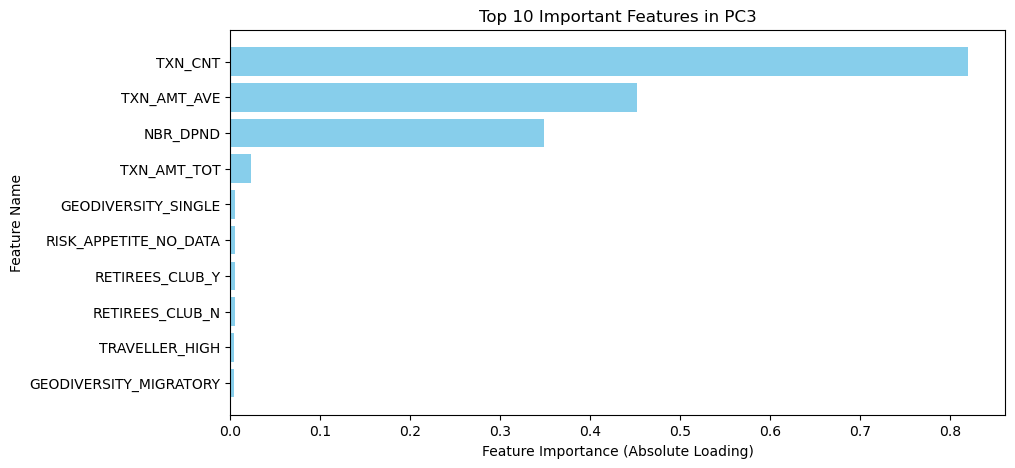

In [39]:
# Choose a principal component (e.g., PC1)
pc_index = 2  # 0 corresponds to PC1

# Sort features by absolute contribution
sorted_features = loadings.iloc[pc_index].abs().sort_values(ascending=False)

# Plot the top 10 features
plt.figure(figsize=(10, 5))
plt.barh(sorted_features.index[:10], sorted_features.values[:10], color='skyblue')
plt.xlabel("Feature Importance (Absolute Loading)")
plt.ylabel("Feature Name")
plt.title(f"Top 10 Important Features in PC{pc_index+1}")
plt.gca().invert_yaxis()
plt.show()

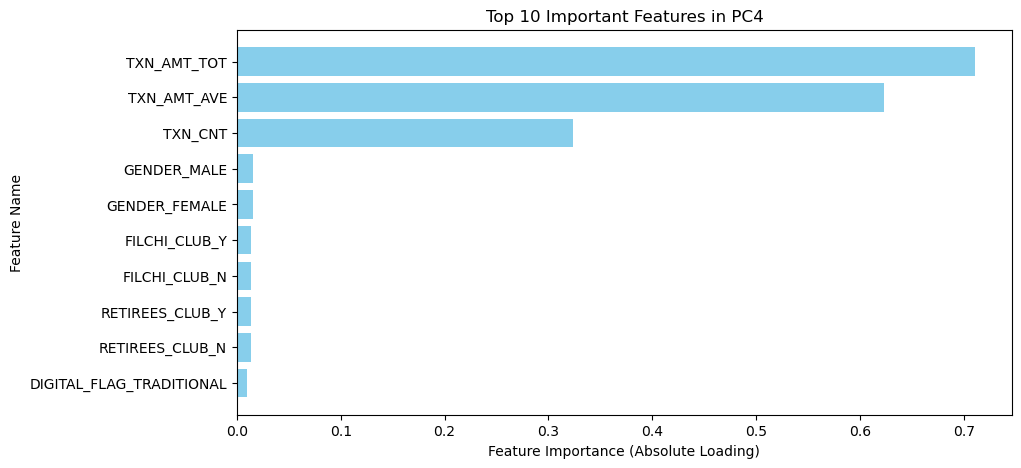

In [41]:
# Choose a principal component (e.g., PC1)
pc_index = 3  # 0 corresponds to PC1

# Sort features by absolute contribution
sorted_features = loadings.iloc[pc_index].abs().sort_values(ascending=False)

# Plot the top 10 features
plt.figure(figsize=(10, 5))
plt.barh(sorted_features.index[:10], sorted_features.values[:10], color='skyblue')
plt.xlabel("Feature Importance (Absolute Loading)")
plt.ylabel("Feature Name")
plt.title(f"Top 10 Important Features in PC{pc_index+1}")
plt.gca().invert_yaxis()
plt.show()

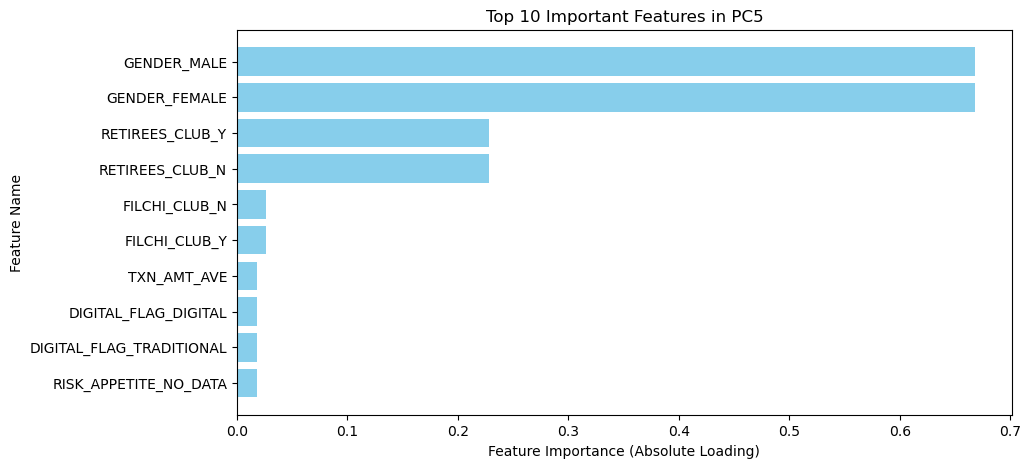

In [43]:
# Choose a principal component (e.g., PC1)
pc_index = 4  # 0 corresponds to PC1

# Sort features by absolute contribution
sorted_features = loadings.iloc[pc_index].abs().sort_values(ascending=False)

# Plot the top 10 features
plt.figure(figsize=(10, 5))
plt.barh(sorted_features.index[:10], sorted_features.values[:10], color='skyblue')
plt.xlabel("Feature Importance (Absolute Loading)")
plt.ylabel("Feature Name")
plt.title(f"Top 10 Important Features in PC{pc_index+1}")
plt.gca().invert_yaxis()
plt.show()

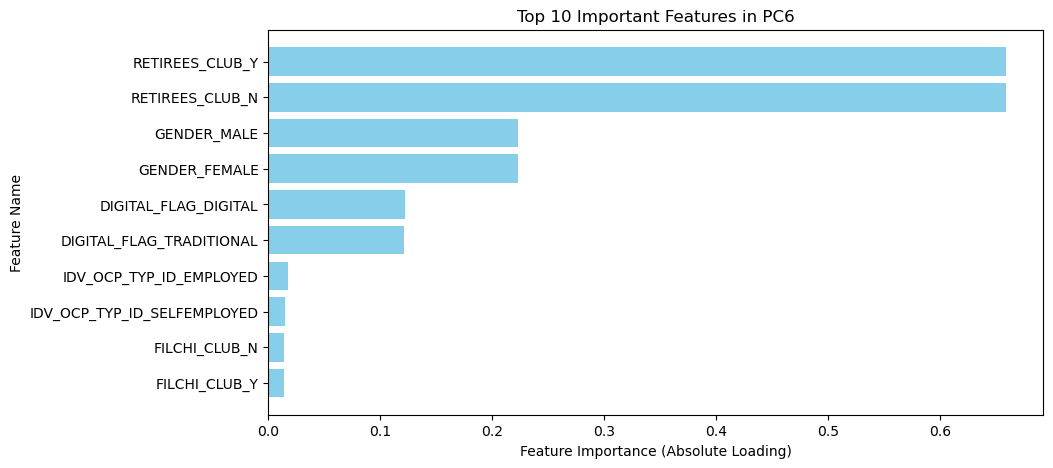

In [47]:
# Choose a principal component (e.g., PC1)
pc_index = 5  # 0 corresponds to PC1

# Sort features by absolute contribution
sorted_features = loadings.iloc[pc_index].abs().sort_values(ascending=False)

# Plot the top 10 features
plt.figure(figsize=(10, 5))
plt.barh(sorted_features.index[:10], sorted_features.values[:10], color='skyblue')
plt.xlabel("Feature Importance (Absolute Loading)")
plt.ylabel("Feature Name")
plt.title(f"Top 10 Important Features in PC{pc_index+1}")
plt.gca().invert_yaxis()
plt.show()

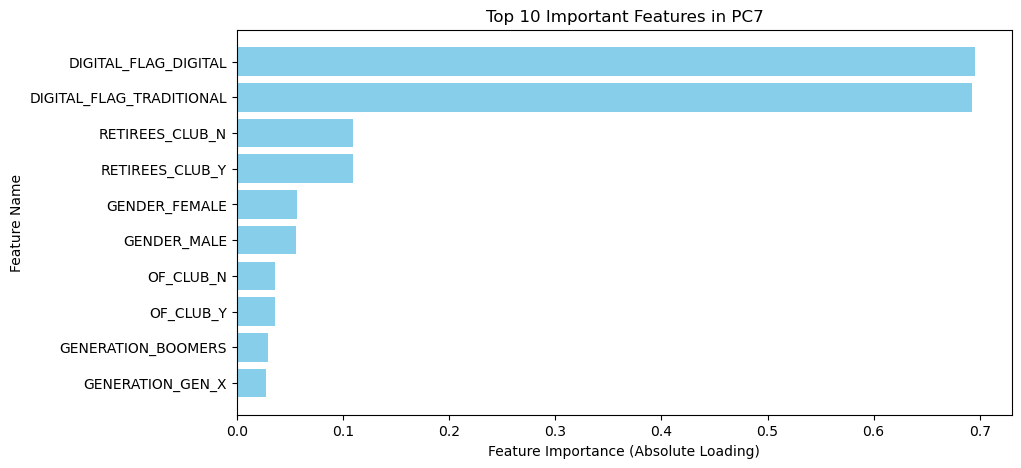

In [49]:
# Choose a principal component (e.g., PC1)
pc_index = 6  # 0 corresponds to PC1

# Sort features by absolute contribution
sorted_features = loadings.iloc[pc_index].abs().sort_values(ascending=False)

# Plot the top 10 features
plt.figure(figsize=(10, 5))
plt.barh(sorted_features.index[:10], sorted_features.values[:10], color='skyblue')
plt.xlabel("Feature Importance (Absolute Loading)")
plt.ylabel("Feature Name")
plt.title(f"Top 10 Important Features in PC{pc_index+1}")
plt.gca().invert_yaxis()
plt.show()

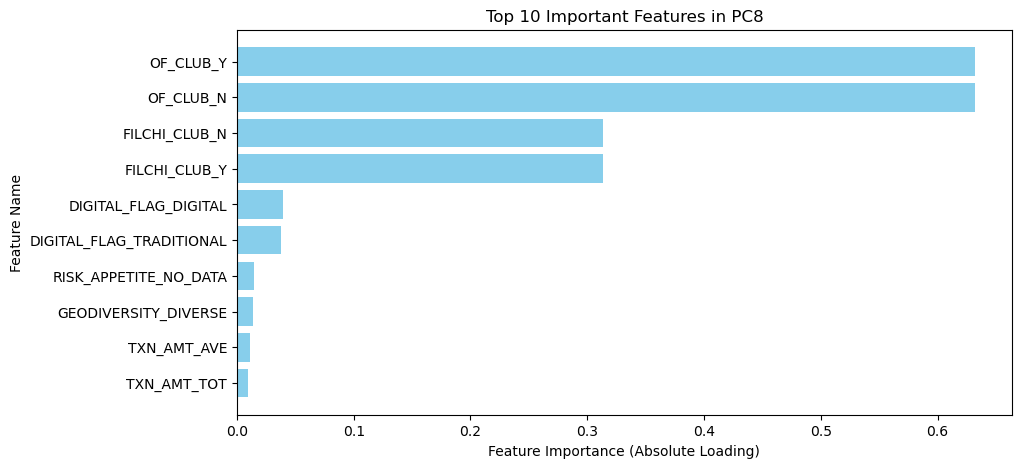

In [51]:
# Choose a principal component (e.g., PC1)
pc_index = 7  # 0 corresponds to PC1

# Sort features by absolute contribution
sorted_features = loadings.iloc[pc_index].abs().sort_values(ascending=False)

# Plot the top 10 features
plt.figure(figsize=(10, 5))
plt.barh(sorted_features.index[:10], sorted_features.values[:10], color='skyblue')
plt.xlabel("Feature Importance (Absolute Loading)")
plt.ylabel("Feature Name")
plt.title(f"Top 10 Important Features in PC{pc_index+1}")
plt.gca().invert_yaxis()
plt.show()

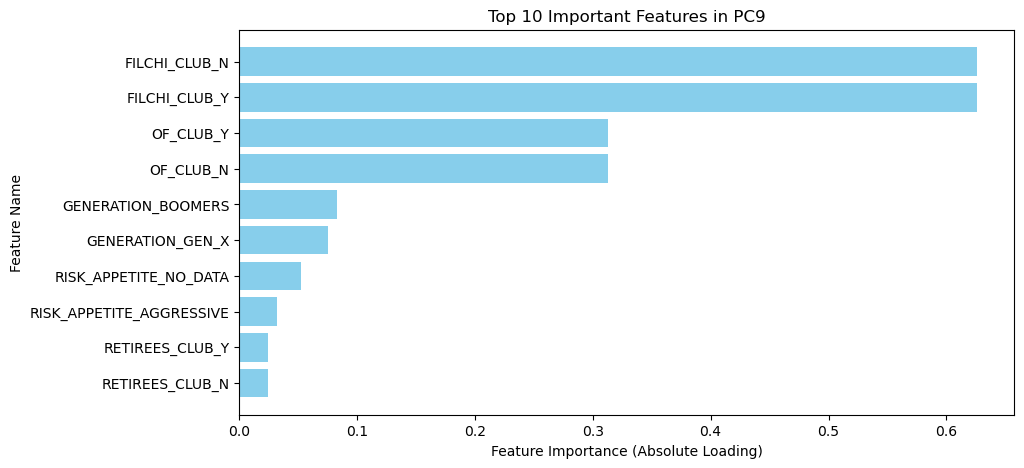

In [53]:
# Choose a principal component (e.g., PC1)
pc_index = 8  # 0 corresponds to PC1

# Sort features by absolute contribution
sorted_features = loadings.iloc[pc_index].abs().sort_values(ascending=False)

# Plot the top 10 features
plt.figure(figsize=(10, 5))
plt.barh(sorted_features.index[:10], sorted_features.values[:10], color='skyblue')
plt.xlabel("Feature Importance (Absolute Loading)")
plt.ylabel("Feature Name")
plt.title(f"Top 10 Important Features in PC{pc_index+1}")
plt.gca().invert_yaxis()
plt.show()

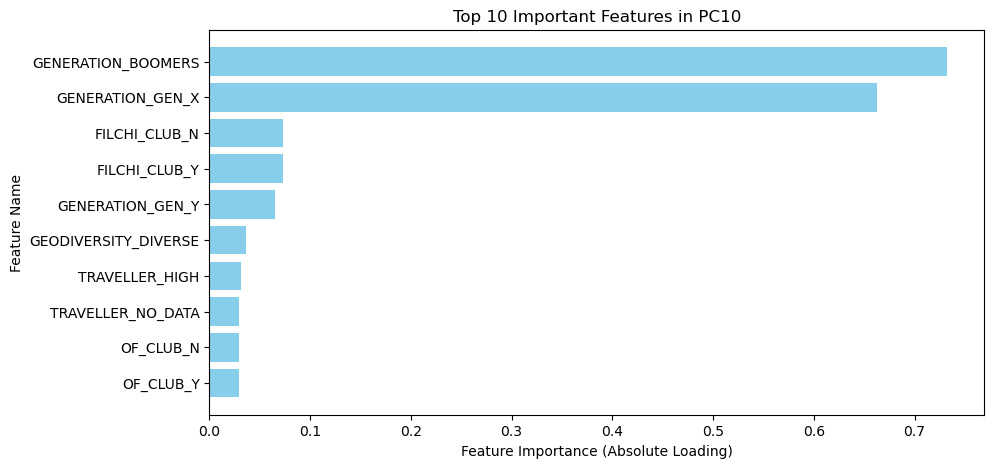

In [55]:
# Choose a principal component (e.g., PC1)
pc_index = 9  # 0 corresponds to PC1

# Sort features by absolute contribution
sorted_features = loadings.iloc[pc_index].abs().sort_values(ascending=False)

# Plot the top 10 features
plt.figure(figsize=(10, 5))
plt.barh(sorted_features.index[:10], sorted_features.values[:10], color='skyblue')
plt.xlabel("Feature Importance (Absolute Loading)")
plt.ylabel("Feature Name")
plt.title(f"Top 10 Important Features in PC{pc_index+1}")
plt.gca().invert_yaxis()
plt.show()

## Insights

### Financial Behavior Dominates the First Few Components (PC1 - PC4)

PC1, PC2, PC3, PC4 are heavily influenced by TXN_AMT_TOT (Total Transaction Amount), TXN_AMT_AVE (Average Transaction Amount), TXN_CNT (Transaction Count), and NBR_DPND (Number of Dependents). This suggests that the most important factors in overall variance are related to financial activity and spending behavior.

Possible Insights:
- Customers with more dependents might have higher spending.
- Transaction count and total spend are closely related, indicating consistent spending patterns.
- Financial segmentation may be a key approach for customer analysis.

### Demographics & Club Memberships Start Influencing PC5 - PC10

PC5 and PC6 introduce gender (Male/Female) and Retirees Club membership (Yes/No). This suggests that gender and retirement status affect customer behavior in ways distinct from raw financial data.

Possible Insights:
- Male and female customers might have different spending behaviors.
- Retirees likely have different spending patterns than working-age individuals.

PC7 focuses on Digital Behavior (Digital vs. Traditional Banking). Digital customers may exhibit different spending or transactional patterns compared to traditional customers.

Possible Insights:
- Digital banking customers might be more engaged with online transactions.
- Traditional banking users could prefer in-person transactions and may have different risk profiles.

PC8 and PC9 highlight Club Memberships (OF_CLUB, FILCHI_CLUB). This suggests that being part of specific social clubs significantly differentiates customers.

Possible Insights:
- Club memberships might correlate with different financial behaviors or lifestyle choices.
- These variables could be useful for targeted marketing campaigns.

PC10 is dominated by Generation (Boomers, Gen X) and Club Memberships. This suggests that generational differences drive distinct spending patterns.

Possible Insights:
- Different generations may have different financial priorities (e.g., Boomers might spend more on healthcare, while Gen X might spend on family expenses).
- Club memberships might be more relevant for certain age groups.

### Final Priority List for Segmentation
TXN_AMT_TOT, TXN_AMT_AVE, TXN_CNT, NBR_DPND for Core financial segmentation

GENDER, GENERATION, MARITAL_STATUS for Demographic-based targeting

DIGITAL_FLAG for Digital vs. Traditional banking segmentation

Club Memberships (RETIREES_CLUB, FILCHI_CLUB, etc.) for Lifestyle-based segmentation